# Homework 5

## FINM 35700 - Spring 2025

### UChicago Financial Mathematics

### Due Date: 2025-04-29

* Matheus Raka Pradnyatama
* matheusraka@uchicago.edu

This homework relies on following data files:

Government and corporate bonds
- the bond symbology file `bond_symbology`, 
- the "on-the-run" treasuries data file `govt_on_the_run`,
- the bond market data file `bond_market_prices_eod`,

Interest Rate & Credit Default Swaps
- the SOFR OIS symbology file `sofr_swap_symbology`,
- the SOFR swaps market data file `sofr_swaps_market_data_eod`,
- the CDS spreads market data file `cds_market_data_eod`.

In [243]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import QuantLib as ql
import datetime as dt
from scipy.optimize import fsolve
from scipy.optimize import root_scalar

# The code is made with the help of OpenAI's ChatGPT.

# import tools from previous homeworks
from credit_market_tools import *

# Use static calculation/valuation date of 2024-12-13, matching data available in the market prices EOD file
calc_date = ql.Date(13, 12, 2024)
ql.Settings.instance().evaluationDate = calc_date

# Calculation/valuation date as pd datetime
as_of_date = pd.to_datetime('2024-12-13')

-----------------------------------------------------------
# Problem 1: Credit Default Swaps (hazard rate model)

## When computing sensitivities, assume "everything else being equal" (ceteris paribus).

For a better understanding of dependencies, you can use the CDS valuation formulas in the simple hazard rate model (formulas[45] and [46] in Lecture 4).

\begin{align}
PV_{CDS\_PL}\left(c,r,h,R,T\right) = \frac{c}{4 \cdot \left(e^{\left(r+h\right)/4}-1 \right)} \cdot\left[1-e^{-T\cdot\left(r+h\right)}\right] \simeq \frac{c}{r+h} \cdot\left[1-e^{-T\cdot\left(r+h\right)}\right]
\end{align}

\begin{align}
PV_{CDS\_DL}\left(c,r,h,R,T\right) = \frac{\left(1-R\right)\cdot h}{r+h} \cdot\left[1-e^{-T\cdot\left(r+h\right)}\right]
\end{align}

\begin{align}
PV_{CDS} = PV_{CDS\_PL} - PV_{CDS\_DL} \simeq \frac{c - \left(1-R\right)\cdot h}{r+h} \cdot\left[1-e^{-T\cdot\left(r+h\right)}\right]
\end{align}

\begin{align}
CDS\_ParSpread = c \cdot \frac{PV_{CDS\_DL}}{PV_{CDS\_PL}} \simeq \left(1-R\right)\cdot h
\end{align}


## a. True or False (CDS Premium Leg PV)

1. CDS premium leg PV is increasing in CDS Par Spread
2. CDS premium leg PV is increasing in interest rate
2. CDS premium leg PV is increasing in hazard rate
3. CDS premium leg PV is increasing in recovery rate
4. CDS premium leg PV is increasing in coupon
5. CDS premium leg PV is increasing in CDS maturity


Using equations 1, 2, 3, 4 above: 

1. <b> FALSE </b>. <br>
If CDS par spread increases, the CDS premium leg PV decreases. <br>
This is straightforward from the last equation. 

2. <b> FALSE </b>. <br>
If interest rate increases, future cash flows are discounted heavier, the CDS premium leg PV decreases. 

3. <b> FALSE </b>. <br>
If hazard rate increases, the CDS premium leg PV decreases. <br>
Last Equation: PV_PL = c * PV_DL / {(1-R)*h}. <br>
If h increases, the denominator increase, the fraction decrease, PV_PL decrease. <br>

4. <b> FALSE </b>. <br>
CDS Premium Leg PV does NOT depend on the Recovery Rate (R).
 
5. <b> TRUE </b>. <br>
If coupon rate increases, the CDS premium leg PV increase.  This is straightforward from the last equation.

6. <b> TRUE </b>. <br>
If maturity increases, more coupons are being added, the CDS premium leg PV increase.  <br>
From the first equation, the e will have a bigger exponent, 1/e^x will get smaller, (1-e^x)  will get bigger, the PV_PL gets bigger. 

## b. True or False (CDS Default Leg PV)

1. CDS default leg PV is increasing in CDS Par Spread
2. CDS default leg PV is increasing in interest rate
3. CDS default leg PV is increasing in hazard rate
4. CDS default leg PV is increasing in recovery rate
5. CDS default leg PV is increasing in coupon
6. CDS default leg PV is increasing in CDS maturity

1. <b> TRUE </b>. Straightforward from last equation. If CDS Par Spread increases, the CDS Default Leg PV increases.
2. <b> FALSE </b>. Any PV calculation will get smaller if interest rates were to increase.
3. <b> TRUE</b>. Straighforward from the last equation. If hazard rate increases, the CDS Default Leg PV increases.
4. <b> FALSE </b>. Straighforward from the last equation. If recovery rate increases, expected loss decrease, the CDS Default Leg PV decreases.
5. <b> FALSE </b>. CDS Default Leg PV does NOT depend on the coupon rate. If c change, in the last equation, the Premium Leg PV will change and the Default Leg PV will remain unchanged. 
6. <b> TRUE </b>. <br>
If maturity increases, an additional default risk is being added, the CDS default leg PV increase. <br>
From the second equation, the e will have a bigger exponent, 1/e^x will get smaller, (1-e^x)  will get bigger, the PV_DL gets bigger. 

## c. True or False (CDS PV)


1. CDS PV is increasing in CDS Par Spread
2. CDS PV is increasing in interest rate
3. CDS PV is increasing in hazard rate
4. CDS PV is increasing in recovery rate
5. CDS PV is increasing in coupon
6. CDS PV is increasing in CDS maturity

1. <b> FALSE </b>. If CDS par spread increase, CDS Premium Leg PV goes down and Default Leg PV goes up, the CDS PV decreases. 
2. <b> FALSE </b>. If interest rate increase, CDS Premium Leg PV goes down and Default Leg PV goes down. There is no certainty on whether CDS PV will increase. 
3. <b> FALSE </b>. If hazard rate increase, CDS Premium Leg PV goes down and Default Leg PV goes up, the CDS PV decreases. 
4. <b> TRUE </b>. If recovery rate increase, CDS Premium Leg PV remains the same, and Default Leg PV goes down, the CDS PV increases. 
5. <b> TRUE </b>. If coupon rate increase, CDS Premium Leg PV goes up and Default Leg PV remains the same, the CDS PV increases. 
6. <b> FALSE </b>. If CDS maturity increase, CDS Premium Leg PV goes up and Default Leg PV goes up. There is no certainty on whether CDS PV will increase.

## d. True or False (CDS Par Spread)


1. CDS Par Spread is increasing in interest rates
2. CDS Par Spread is increasing in hazard rate
3. CDS Par Spread is increasing in recovery rate
4. CDS Par Spread is increasing in coupon
5. CDS Par Spread is increasing in CDS maturity

1. <b> FALSE </b>. If interest rates increase, CDS Premium Leg PV goes down and Default Leg PV goes down. There is no certainty on whether CDS Par Spread will increase. 
2. <b> TRUE </b>. If hazard rate increase, CDS Premium Leg PV goes down and Default Leg PV goes up, the CDS Par Spread increases. 
3. <b> FALSE </b>. If recovery rate increase, CDS Premium Leg PV remains unchanged and Default Leg PV goes down, the CDS Par Spread decreases. 
4. <b> FALSE </b>. If coupon rate increase, CDS Premium Leg PV goes up and Default Leg PV remains unchanged, the CDS Par Spread decreases. 
5. <b> FALSE </b>. If CDS maturity increase, CDS Premium Leg PV goes up and Default Leg PV goes up. There is no certainty on whether CDS Par Spread will increase.

-----------------------------------------------------------
# Problem 2: Perpetual CDS
We are interested in a perpetual CDS contract (infinite maturity) on a face notional of $100, flat interest rate of 4% and coupon of 1% (quarterly payments).

For simplicity, we assuming a flat hazard rate of 2% per annum, a recovery rate of 40%, T+0 settlement and zero accrued.

Use the simple CDS valuation formulas derived in Session 4 as a template.

## a. Compute the fair value of the CDS premium and default legs.


Formula derivation is in the word document (PDF version) that is also submitted.

In [244]:
def calc_perpetual_cds_premium_leg_pv(c,r,h,R,face):
    return(c / 4 / (np.exp((r+h)/4)-1) * face)

def calc_perpetual_cds_default_leg_pv(c,r,h,R,face):
    return((1 - R) * h / (r + h) * face)

def calc_perpetual_cds_pv(c,r,h,R,face):
    return(calc_perpetual_cds_premium_leg_pv(c,r,h,R,face) - calc_perpetual_cds_default_leg_pv(c,r,h,R,face))

def calc_perpetual_cds_upfront(c,r,h,R,face):
    return(- calc_perpetual_cds_pv(c,r,h,R,face))

def calc_perpetual_cds_par_spread(c,r,h,R,face):
    return(c * calc_perpetual_cds_default_leg_pv(c,r,h,R,face) / calc_perpetual_cds_premium_leg_pv(c,r,h,R,face))

In [245]:
r = 4/100
h = 2/100  # 2% per annum
R = 40/100
c = 1/100 # Quarterly coupon 
face = 100

denominator = 1 - np.exp(-(r+h)/4) 

# CDS PV for each leg
cds_premium_pv =  calc_perpetual_cds_premium_leg_pv(c,r,h,R,face)
cds_default_pv =  calc_perpetual_cds_default_leg_pv(c,r,h,R,face)

print('CDS Premium Leg PV:', round(cds_premium_pv, 4))
print('CDS Default Leg PV:', round(cds_default_pv, 4))

CDS Premium Leg PV: 16.542
CDS Default Leg PV: 20.0


## b. Compute the CDS PV, the CDS Upfront and the CDS Par Spread.

In [246]:
cds_pv_base = calc_perpetual_cds_pv(c,r,h,R,face)
upfront = calc_perpetual_cds_upfront(c,r,h,R,face)
perpetual_cds_par_spread = calc_perpetual_cds_par_spread(c,r,h,R,face)
perpetual_cds_par_spread_bps = calc_perpetual_cds_par_spread(c,r,h,R,face) * 10_000

print('CDS PV:', round(cds_pv_base, 4))    
print("CDS Upfront Payment:", round(upfront, 4))
print('CDS fair/par spread:', round(perpetual_cds_par_spread, 4))
print('CDS fair/par spread (bps):', round(perpetual_cds_par_spread_bps, 1))

CDS PV: -3.458
CDS Upfront Payment: 3.458
CDS fair/par spread: 0.0121
CDS fair/par spread (bps): 120.9


## c. Compute the following CDS risk sensitivities:
- IR01 (PV sensitivity to Interest Rate change of '-1bp')
- HR01 (PV sensitivity to Hazard Rate change of '-1bp')
- REC01 (PV sensitivity to Recovery Rate change of '+1%')

using the scenario method.


In [247]:
# Interest Rate Shift

# constant model parameters
r = 0.04 - 1/10_000
c = 0.01
h = 0.02
R = 0.40 
face = 100

cds_pv_scen = calc_perpetual_cds_pv(c,r,h,R,face)

# CDS IR01
CDS_IR01 = (cds_pv_scen - cds_pv_base)
print('CDS PV (Base Scenario):', round(cds_pv_base, 4))    
print('CDS PV (Scenario: -1bps Shift in Interest Rate):', round(cds_pv_scen, 4))    
print('CDS IR01:', round(CDS_IR01, 4))   

CDS PV (Base Scenario): -3.458
CDS PV (Scenario: -1bps Shift in Interest Rate): -3.4636
CDS IR01: -0.0056


In [248]:
# Hazard Rate Shift

# constant model parameters
r = 0.04
c = 0.01
h = 0.02 - 1/10_000
R = 0.40 
face = 100

cds_pv_scen = calc_perpetual_cds_pv(c,r,h,R,face)

# CDS HR01
CDS_HR01 = (cds_pv_scen - cds_pv_base)
print('CDS PV (Base Scenario):', round(cds_pv_base, 4))    
print('CDS PV (Scenario: -1bps Shift in Hazard Rate):', round(cds_pv_scen, 4))    
print('CDS HR01:', round(CDS_HR01, 4))   

# CDS CS01 = HR01 / (Change in Perpetual CDS due to Hazard Rate Shift)
perpetual_cds_par_spread_h_1bp_down = calc_perpetual_cds_par_spread(c,r,h,R,face) * 10_000
perpetual_cds_par_spread_bps_delta = perpetual_cds_par_spread_bps - perpetual_cds_par_spread_h_1bp_down
CDS_CS01 = CDS_HR01 / (perpetual_cds_par_spread_bps_delta)

print('\nCDS Par Spread (Base Scenario, bps):', round(perpetual_cds_par_spread_bps, 4))    
print('CDS Par Spread (Scenario: -1bps Shift in Hazard Rate, bps):', round(perpetual_cds_par_spread_h_1bp_down, 4))    
print('CDS CS01:', round(CDS_CS01, 2))  

CDS PV (Base Scenario): -3.458
CDS PV (Scenario: -1bps Shift in Hazard Rate): -3.3634
CDS HR01: 0.0946

CDS Par Spread (Base Scenario, bps): 120.9045
CDS Par Spread (Scenario: -1bps Shift in Hazard Rate, bps): 120.2985
CDS CS01: 0.16


In [249]:
# Recovery Rate Shift

# constant model parameters
r = 0.04
c = 0.01
h = 0.02
R = 0.40 + 1/100
face = 100

cds_pv_scen = calc_perpetual_cds_pv(c,r,h,R,face)

# CDS REC01
CDS_REC01 = (cds_pv_scen - cds_pv_base)
print('CDS PV (Base Scenario):', round(cds_pv_base, 4))    
print('CDS PV (Scenario: +1% Shift in Recovery Rate):', round(cds_pv_scen, 4))    
print('CDS REC01:', round(CDS_REC01, 4))   

CDS PV (Base Scenario): -3.458
CDS PV (Scenario: +1% Shift in Recovery Rate): -3.1247
CDS REC01: 0.3333


## d. At what time T does the (implied) default probability over next 10 years (from $[T, T+10]$) drop to 10%?

\begin{align}
\mathbb{P} \left(\tau \in [T, T+10] \right) = 10/100
\end{align}


In [250]:
# Formula derivation is in the Word document (PDF version submitted)

h = 2/100
log_part = 10 - 10 * np.exp(-10*h)
time_T = np.log(log_part) / h

print('Time T when the (implied) default probability over the next 10 years drop to 10%:', round(time_T, 4))   

Time T when the (implied) default probability over the next 10 years drop to 10%: 29.7407


-----------------------------------------------------------
# Problem 3: Pricing risky bonds in the hazard rate model
## This is building upon
- Homework 2 "Problem 2: US Treasury yield curve calibration (On-The-Runs)",
- Homework 4 "Problem 2: US SOFR swap curve calibration" and
- Homework 4 "Problem 3: CDS Hazard Rate calibration".

## a. Prepare the market data
### Load the symbology + market data dataframes. Calibrate the following curves as of 2024-12-13:
- the "on-the-run" US Treasury curve,
- the US SOFR curve and 
- the IBM CDS hazard rate curve (on the top of SOFR discount curve).


,date,isin,bidPrice,askPrice,midPrice,bidYield,askYield,midYield,term,TTM
0,2024-12-13,US91282CMB45,99.3750,99.3828,99.37890,4.224,4.221,4.2225,2.995209,3.003422
1,2024-12-13,US91282CLY56,100.0000,100.0078,100.00390,4.249,4.245,4.2470,1.993155,1.963039
2,2024-12-13,US91282CMA61,99.4375,99.4453,99.44140,4.252,4.250,4.2510,4.993840,4.963723
3,2024-12-13,US91282CLZ22,98.7969,98.8125,98.80470,4.327,4.324,4.3255,6.992471,6.962355
4,2024-12-13,US91282CLW90,98.8125,98.8281,98.82030,4.399,4.397,4.3980,9.998631,9.921971
5,2024-12-13,US912810UE63,98.3281,98.3594,98.34375,4.603,4.601,4.6020,29.998631,29.921971
6,2024-12-13,US912810UF39,99.2500,99.2813,99.26565,4.683,4.681,4.6820,19.953457,19.923340


,Date,YearFrac,DiscountFactor,ZeroRate
0,2024-12-13,0.000,1.000,4.127
1,2026-11-30,2.000,0.921,4.212
2,2027-12-15,3.000,0.882,4.279
3,2029-11-30,5.000,0.812,4.263
4,2031-11-30,7.000,0.742,4.357
5,2034-11-15,9.917,0.648,4.475
6,2044-11-15,19.917,0.390,4.839
7,2054-11-15,29.917,0.256,4.654


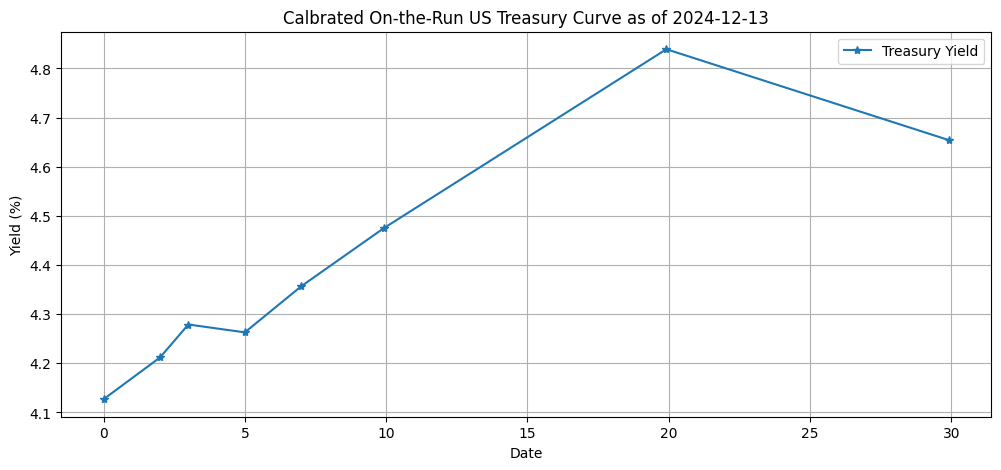

In [251]:
filepath_rawdata = f'./data/govt_on_the_run.xlsx'
df_govt = pd.read_excel(filepath_rawdata)
# r'[BC] Govt$' matches string that ends with B Govt or C Govt
# ~ negates the filter, showing rows that DO NOT match the filter (those that don't have BC)
df_ontherun = df_govt[~df_govt['ticker'].str.contains(r'[BC] Govt$', regex=True)]
# display(df_ontherun.head(3))

# Bond Symbology Dataframe = Containing both corporate and US Government Bonds
filepath_rawdata = f'./data/bond_symbology.xlsx'
bond_symbology = pd.read_excel(filepath_rawdata)
days_in_year = 365.25
date_today = pd.to_datetime('2024-12-13')
bond_symbology['term'] = ((bond_symbology['maturity']) - bond_symbology['start_date']).dt.days /days_in_year
bond_symbology['TTM'] = ((bond_symbology['maturity'] - date_today)).dt.days /days_in_year
bond_symbology.loc[bond_symbology['TTM'] <= 0, 'TTM'] = 0 # If TTM is less than or equal to 0, then it's 0
# display(bond_symbology.head(3))

# Dataframe of market prices
filepath_rawdata = f'./data/bond_market_prices_eod.xlsx'
data_market = pd.read_excel(filepath_rawdata)
data_market['midPrice'] = (data_market['bidPrice'] + data_market['askPrice'])/2
data_market['midYield'] = (data_market['bidYield'] + data_market['askYield'])/2
# display(data_market.head(3))

# Symbology + Market
df_merged_symbo_market = pd.merge(data_market, bond_symbology, on=['isin', 'class', 'figi', 'ticker'], how='inner')

# Symbology + Market + On the Run
govt_combined_otr = pd.merge(df_merged_symbo_market, df_ontherun['isin'], on=['isin'], how='inner')

display(govt_combined_otr[['date', 'isin', 'bidPrice', 'askPrice', 'midPrice', 'bidYield', 'askYield', 'midYield', 'term', 'TTM']])

# tsy_yield_curve calibration
govt_combined_otr = govt_combined_otr
tsy_yield_curve = calibrate_yield_curve_from_frame(calc_date, govt_combined_otr, 'midPrice')
tsy_yield_curve_handle = ql.YieldTermStructureHandle(tsy_yield_curve)

tsy_yield_curve_mid_details = get_yield_curve_details_df(tsy_yield_curve, curve_dates=None)
display(tsy_yield_curve_mid_details)

# Input for Scatter Plot
plt.figure(figsize=(12, 5))
plt.plot(tsy_yield_curve_mid_details['YearFrac'], tsy_yield_curve_mid_details['ZeroRate'], '*-', label='Treasury Yield')
plt.title(f'Calbrated On-the-Run US Treasury Curve as of {calc_date.to_date()}')
plt.xlabel('Date')
plt.ylabel('Yield (%)')
plt.legend()
plt.grid()
plt.show()

,date,figi,ticker,tenor,midRate,dcc
234,2024-12-13,BBG00KFWPJJ9,USOSFR1,1,4.19080,ACT/360
469,2024-12-13,BBG00KFWPJX3,USOSFR2,2,4.05545,ACT/360
704,2024-12-13,BBG00KFWPK15,USOSFR3,3,3.99135,ACT/360
939,2024-12-13,BBG00KFWPK51,USOSFR5,5,3.91570,ACT/360
1174,2024-12-13,BBG00KFWPK79,USOSFR7,7,3.89640,ACT/360
1409,2024-12-13,BBG00KFWPKB4,USOSFR10,10,3.90400,ACT/360
1643,2024-12-13,BBG00KFWPKF0,USOSFR20,20,3.92750,ACT/360
1878,2024-12-13,BBG00KFWPKH8,USOSFR30,30,3.76320,ACT/360


,Date,YearFrac,DiscountFactor,ZeroRate
0,2024-12-16,0.000,1.000,4.190
1,2025-12-16,1.014,0.959,4.190
2,2026-12-16,2.028,0.923,4.052
3,2027-12-16,3.042,0.888,3.986
4,2028-12-16,4.058,0.855,3.946
5,2029-12-16,5.072,0.823,3.907
6,2030-12-16,6.086,0.792,3.897
7,2031-12-16,7.100,0.763,3.888
8,2032-12-16,8.117,0.734,3.892
9,2033-12-16,9.131,0.705,3.895


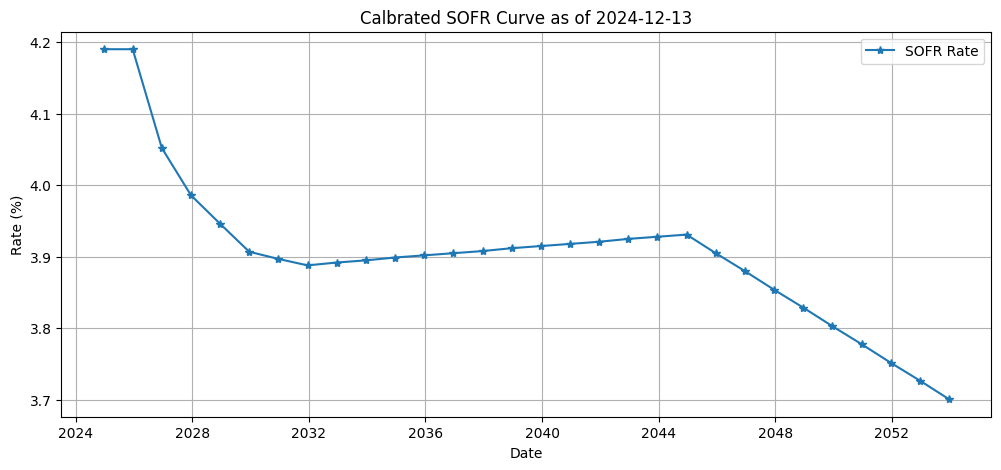

In [252]:
# sofr_swaps_symbology Dataframe
filepath_rawdata = f'./data/sofr_swaps_symbology.xlsx'
sofr_swaps_symbology = pd.read_excel(filepath_rawdata)
# display(sofr_swaps_symbology)

# sofr_swaps_market_data_eod Dataframe
filepath_rawdata = f'./data/sofr_swaps_market_data_eod.xlsx'
sofr_swaps_market_data_eod = pd.read_excel(filepath_rawdata)

# Merge Data to give Tenor
sofr_combined = pd.merge(sofr_swaps_symbology, sofr_swaps_market_data_eod, on=['figi'], how='inner')

# Include only data from the as_of_date
sofr_combined = sofr_combined[sofr_combined['date'] == as_of_date]
display(sofr_combined[['date', 'figi', 'ticker', 'tenor', 'midRate','dcc']])

# sofr_yield_curve calibration

# Calibrating the Yield Curve
calc_date = calc_date
sofr_details =  sofr_combined
rate_quote_column = 'midRate' # Name of the Rate column

# Create SOFR Yield Curve
sofr_yield_curve = calibrate_sofr_curve_from_frame(calc_date, sofr_details, rate_quote_column)
sofr_yield_curve_handle = ql.YieldTermStructureHandle(sofr_yield_curve)

# Display SOFR yield curve
grid_dates = [sofr_yield_curve.referenceDate() + ql.Period(y, ql.Years) for y in list(range(0,30,1))]
sofr_yield_curve_simple_df = get_yield_curve_details_df(sofr_yield_curve)                  # using calibration grid
sofr_yield_curve_details_df = get_yield_curve_details_df(sofr_yield_curve, grid_dates)    # using external grid
# display(sofr_yield_curve_simple_df)
display(sofr_yield_curve_details_df)

plt.figure(figsize=(12, 5))
plt.plot(sofr_yield_curve_details_df['Date'], sofr_yield_curve_details_df['ZeroRate'], '*-', label='SOFR Rate')
plt.title(f'Calbrated SOFR Curve as of {calc_date.to_date()}')
plt.xlabel('Date')
plt.ylabel('Rate (%)')
plt.legend()
plt.grid()
plt.show()

,date,par_spread_1y,par_spread_2y,par_spread_3y,par_spread_5y,par_spread_7y,par_spread_10y
238,2024-12-13,10.9082,15.6009,22.4095,35.4733,50.8816,61.462


,Date,YearFrac,HazardRate,SurvivalProb
0,2024-12-13,0.000000,0.179862,1.000000
1,2025-12-22,1.038889,0.179862,0.998133
2,2026-12-21,2.050000,0.341810,0.994690
3,2027-12-20,3.061111,0.614840,0.988525
4,2029-12-20,5.091667,0.953377,0.969572
5,2031-12-22,7.125000,1.604396,0.938453
6,2034-12-20,10.163889,1.551602,0.895230


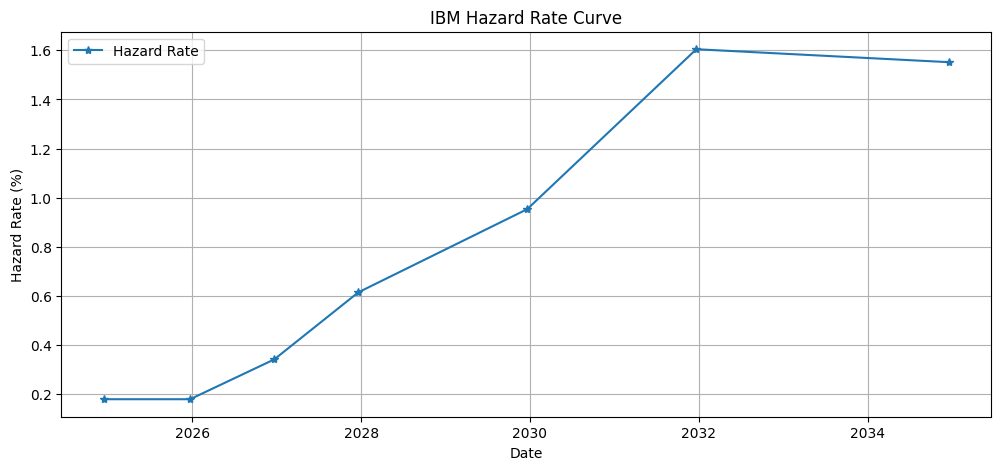

In [253]:
# sofr_swaps_market_data_eod Dataframe

filepath_rawdata = f'./data/cds_market_data_eod.xlsx'
cds_market_data_eod = pd.read_excel(filepath_rawdata)

cds_market_data_eod_current = cds_market_data_eod[cds_market_data_eod['date'] == as_of_date]
par_spread_df = cds_market_data_eod_current[['date',
                                            'par_spread_1y', 
                                             'par_spread_2y', 
                                             'par_spread_3y', 
                                             'par_spread_5y', 
                                             'par_spread_7y', 
                                             'par_spread_10y', 
                                             ]]
# Par Spread as of as_of_date
display(par_spread_df)

# Get the values as list
par_spread_list = par_spread_df.iloc[-1][1:].tolist()
# print(par_spread_list)

# settle_days
settle_days = 1

# Yield Curve Handle
sofr_yield_curve_handle = ql.YieldTermStructureHandle(sofr_yield_curve)

CDS_recovery_rate = 0.4

CDS_day_count = ql.Actual360()

# CDS standard tenors: 1Y, 2Y, 3Y, 5Y 7Y and 10Y
CDS_tenors = [ql.Period(y, ql.Years) for y in [1, 2, 3, 5, 7, 10]]
              
# CDS spreads for IBM as of calc_date = 2024-12-13
CDS_spreads = par_spread_list # In bps

CDS_helpers = [ql.SpreadCdsHelper((CDS_spread / 10_000.0), CDS_tenor, settle_days, ql.TARGET(),
                ql.Quarterly, ql.Following, ql.DateGeneration.TwentiethIMM, CDS_day_count, CDS_recovery_rate, sofr_yield_curve_handle)               
                for (CDS_spread, CDS_tenor) in zip(CDS_spreads, CDS_tenors)]

# bootstrap hazard_rate_curve
hazard_rate_curve = ql.PiecewiseFlatHazardRate(calc_date, CDS_helpers, CDS_day_count)
hazard_rate_curve.enableExtrapolation()

# Display calibrated hazard rates and survival probabilities
hazard_list = [(hr[0].to_date(), 
                CDS_day_count.yearFraction(calc_date, hr[0]),
                hr[1] * 100,
                hazard_rate_curve.survivalProbability(hr[0]))   # Survival Prob
                # 1-hazard_rate_curve.survivalProbability(hr[0])) # Default Prob
                for hr in hazard_rate_curve.nodes()]

grid_dates, year_frac, hazard_rates, surv_probs = zip(*hazard_list)

hazard_rates_df = pd.DataFrame(data={'Date': grid_dates, 
                                     'YearFrac': year_frac,
                                     'HazardRate': hazard_rates,
                                     'SurvivalProb': surv_probs})
display(hazard_rates_df)

# hazard_rate_curve calibrated to IBM CDS par spreads
hazard_rate_curve = hazard_rate_curve    
default_prob_curve_handle = ql.DefaultProbabilityTermStructureHandle(hazard_rate_curve)

plt.figure(figsize=(12, 5))
plt.plot(hazard_rates_df['Date'], hazard_rates_df['HazardRate'], '*-', label='Hazard Rate')
plt.title('IBM Hazard Rate Curve')
plt.xlabel('Date')
plt.ylabel('Hazard Rate (%)')
plt.legend()
plt.grid()
plt.show()

## b. Create the IBM risky bond objects
### Identify the following 3 IBM fixed rate bonds in the symbology table and create the corresponding fixed rate bonds (3 bond objects).

- security = 'IBM 3.3 01/27/27' / figi = 'BBG00FVNGFP3'
- security = 'IBM 6 1/2 01/15/28' / figi = 'BBG000058NM4'
- security = 'IBM 3 1/2 05/15/29' / figi = 'BBG00P3BLH14'


Use the create_bond_from_symbology() function (discussed in from Homework 2) to create the bonds objects.

Display the bond cashflows using the get_bond_cashflows() function.

In [254]:
figi_IBM_1 = 'BBG00FVNGFP3'
figi_IBM_2 = 'BBG000058NM4'
figi_IBM_3 = 'BBG00P3BLH14'

In [255]:
# Bond Symbology Dataframe = Containing both corporate and US Government Bonds
filepath_rawdata = f'./data/bond_symbology.xlsx'
bond_symbology = pd.read_excel(filepath_rawdata)
days_in_year = 365.25
date_today = pd.to_datetime('2024-12-13')
bond_symbology['term'] = ((bond_symbology['maturity']) - bond_symbology['start_date']).dt.days /days_in_year
bond_symbology['TTM'] = ((bond_symbology['maturity'] - date_today)).dt.days /days_in_year
bond_symbology.loc[bond_symbology['TTM'] <= 0, 'TTM'] = 0 # If TTM is less than or equal to 0, then it's 0
# display(bond_symbology.head(3))

# Row from Symbology Dataframe
bond_details = bond_symbology[bond_symbology['figi'] == figi_IBM_1].iloc[0]
# Today's Date
print(f"Today's date: {calc_date}")
# Security Name
security_name = bond_details['security']
security_figi = bond_details['figi']
print(f"Security: {security_name}, FIGI: {security_figi}")

# Cash Flow
bond_1 = create_bond_from_symbology(bond_details) 
df_cashflow_security = get_bond_cashflows(bond_1, calc_date)
display(df_cashflow_security)

Today's date: December 13th, 2024
Security: IBM 3.3 01/27/27, FIGI: BBG00FVNGFP3


,CashFlowDate,CashFlowYearFrac,CashFlowAmount
15,"January 27th, 2025",0.122222,1.65
16,"July 27th, 2025",0.622222,1.65
17,"January 27th, 2026",1.122222,1.65
18,"July 27th, 2026",1.622222,1.65
19,"January 27th, 2027",2.122222,1.65
20,"January 27th, 2027",2.122222,100.00


In [256]:
# Row from Symbology Dataframe
bond_details = bond_symbology[bond_symbology['figi'] == figi_IBM_2].iloc[0]
# Today's Date
print(f"Today's date: {calc_date}")
# Security Name
security_name = bond_details['security']
security_figi = bond_details['figi']
print(f"Security: {security_name}, FIGI: {security_figi}")

# Cash Flow
bond_2 = create_bond_from_symbology(bond_details) 
df_cashflow_security = get_bond_cashflows(bond_2, calc_date)
display(df_cashflow_security)

# Row from Symbology Dataframe
bond_details = bond_symbology[bond_symbology['figi'] == figi_IBM_3].iloc[0]
# Today's Date
print(f"Today's date: {calc_date}")
# Security Name
security_name = bond_details['security']
security_figi = bond_details['figi']
print(f"Security: {security_name}, FIGI: {security_figi}")

# Cash Flow
bond_3 = create_bond_from_symbology(bond_details) 
df_cashflow_security = get_bond_cashflows(bond_3, calc_date)
display(df_cashflow_security)

Today's date: December 13th, 2024
Security: IBM 6 1/2 01/15/28, FIGI: BBG000058NM4


,CashFlowDate,CashFlowYearFrac,CashFlowAmount
54,"January 15th, 2025",0.088889,3.25
55,"July 15th, 2025",0.588889,3.25
56,"January 15th, 2026",1.088889,3.25
57,"July 15th, 2026",1.588889,3.25
58,"January 15th, 2027",2.088889,3.25
59,"July 15th, 2027",2.588889,3.25
60,"January 15th, 2028",3.088889,3.25
61,"January 15th, 2028",3.088889,100.00


Today's date: December 13th, 2024
Security: IBM 3 1/2 05/15/29, FIGI: BBG00P3BLH14


,CashFlowDate,CashFlowYearFrac,CashFlowAmount
11,"May 15th, 2025",0.422222,1.75
12,"November 15th, 2025",0.922222,1.75
13,"May 15th, 2026",1.422222,1.75
14,"November 15th, 2026",1.922222,1.75
15,"May 15th, 2027",2.422222,1.75
16,"November 15th, 2027",2.922222,1.75
17,"May 15th, 2028",3.422222,1.75
18,"November 15th, 2028",3.922222,1.75
19,"May 15th, 2029",4.422222,1.75
20,"May 15th, 2029",4.422222,100.00


## c. Compute CDS-implied (intrinsic) prices for the IBM fixd rate bonds

Price the 3 IBM bonds using the CDS-calibrated hazard rate curve for IBM (via RiskyBondEngine, discussed in the QuantLib Advanced examples notebook).

Display the clean prices and yields for the 3 test bonds.

You can use the example code below.


In [257]:
figi_IBM_1 = 'BBG00FVNGFP3'
figi_IBM_2 = 'BBG000058NM4'
figi_IBM_3 = 'BBG00P3BLH14'
figi_list = [figi_IBM_1, figi_IBM_2, figi_IBM_3]

In [258]:
# flat_recovery_rate: use market convention of 40% for "Senior Unsecured" Debt
flat_recovery_rate = 0.40

# Bond 1
fixed_rate_bond = bond_1
# Risky bond engine uses the calibrated CDS hazard rate curve for pricing credit default risk 
risky_bond_engine = ql.RiskyBondEngine(default_prob_curve_handle, flat_recovery_rate, tsy_yield_curve_handle)
fixed_rate_bond.setPricingEngine(risky_bond_engine)
corpBondModelPrice_1 = fixed_rate_bond.cleanPrice()
corpBondModelYield_1 = fixed_rate_bond.bondYield(corpBondModelPrice_1, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual) * 100
print(f"For FIGI: {figi_IBM_1}")
print(f"Corporate Bond Model Clean Price: ${corpBondModelPrice_1:,.4f}")
print(f"Corporate Bond Model Yield: {corpBondModelYield_1:,.4f}%")

# Bond 2
fixed_rate_bond = bond_2
# Risky bond engine uses the calibrated CDS hazard rate curve for pricing credit default risk 
risky_bond_engine = ql.RiskyBondEngine(default_prob_curve_handle, flat_recovery_rate, tsy_yield_curve_handle)
fixed_rate_bond.setPricingEngine(risky_bond_engine)
corpBondModelPrice_2 = fixed_rate_bond.cleanPrice()
corpBondModelYield_2 = fixed_rate_bond.bondYield(corpBondModelPrice_2, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual) * 100
print(f"\nFor FIGI: {figi_IBM_2}")
print(f"Corporate Bond Model Clean Price: ${corpBondModelPrice_2:,.4f}")
print(f"Corporate Bond Model Yield: {corpBondModelYield_2:,.4f}%")

# Bond 3
fixed_rate_bond = bond_3
# Risky bond engine uses the calibrated CDS hazard rate curve for pricing credit default risk 
risky_bond_engine = ql.RiskyBondEngine(default_prob_curve_handle, flat_recovery_rate, tsy_yield_curve_handle)
fixed_rate_bond.setPricingEngine(risky_bond_engine)
corpBondModelPrice_3 = fixed_rate_bond.cleanPrice()
corpBondModelYield_3 = fixed_rate_bond.bondYield(corpBondModelPrice_3, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual) * 100
print(f"\nFor FIGI: {figi_IBM_3}")
print(f"Corporate Bond Model Clean Price: ${corpBondModelPrice_3:,.4f}")
print(f"Corporate Bond Model Yield: {corpBondModelYield_3:,.4f}%")

For FIGI: BBG00FVNGFP3
Corporate Bond Model Clean Price: $98.0645
Corporate Bond Model Yield: 4.2657%

For FIGI: BBG000058NM4
Corporate Bond Model Clean Price: $105.7927
Corporate Bond Model Yield: 4.4647%

For FIGI: BBG00P3BLH14
Corporate Bond Model Clean Price: $95.8492
Corporate Bond Model Yield: 4.5478%


In [259]:
figi_IBM_1 = 'BBG00FVNGFP3'
figi_IBM_2 = 'BBG000058NM4'
figi_IBM_3 = 'BBG00P3BLH14'
figi_list = [figi_IBM_1, figi_IBM_2, figi_IBM_3]

model_price_list = [corpBondModelPrice_1, corpBondModelPrice_2, corpBondModelPrice_3]
model_yield_list = [corpBondModelYield_1, corpBondModelYield_2, corpBondModelYield_3]

# Create DataFrame
df_model_results = pd.DataFrame({
    'figi': figi_list,
    'modelPrice': model_price_list,
    'modelYield': model_yield_list
})

# View result
display(df_model_results)

,figi,modelPrice,modelYield
0,BBG00FVNGFP3,98.064510,4.265698
1,BBG000058NM4,105.792709,4.464726
2,BBG00P3BLH14,95.849242,4.547835


## d. Compute the "intrinsic" vs market price basis for the IBM bonds

Load the market mid prices and yields from the bond market data dataframe as of 2024-04-19. 

Compute and display the basis between the "CDS-implied intrinsic" vs market prices and yields:

- basisPrice = modelPrice - midPrice
- basisYield = modelYield - midYield


Are the CDS intrinsic prices lower or higher than the bond prices observed on the market? What factors could explain the basis?

In [260]:
# Dataframe of market prices
filepath_rawdata = f'./data/bond_market_prices_eod.xlsx'
data_market = pd.read_excel(filepath_rawdata)
data_market['midPrice'] = (data_market['bidPrice'] + data_market['askPrice'])/2
data_market['midYield'] = (data_market['bidYield'] + data_market['askYield'])/2

# Grab only the relevant bonds
data_market_ibm = data_market[data_market['figi'].isin(figi_list)]
data_market_ibm[['figi', 'midPrice', 'midYield']]

,figi,midPrice,midYield
74,BBG00P3BLH14,95.4065,4.6630
91,BBG000058NM4,105.3015,4.6315
96,BBG00FVNGFP3,97.4820,4.5615


In [261]:
# Merge Data
df_merged_ibm = pd.merge(data_market_ibm[['figi', 'midPrice', 'midYield']], df_model_results, on=['figi'], how='inner')
df_merged_ibm['basisPrice'] = df_merged_ibm['modelPrice'] - df_merged_ibm['midPrice']
df_merged_ibm['basisYield'] = df_merged_ibm['modelYield'] - df_merged_ibm['midYield']
display(df_merged_ibm)

,figi,midPrice,midYield,modelPrice,modelYield,basisPrice,basisYield
0,BBG00P3BLH14,95.4065,4.6630,95.849242,4.547835,0.442742,-0.115165
1,BBG000058NM4,105.3015,4.6315,105.792709,4.464726,0.491209,-0.166774
2,BBG00FVNGFP3,97.4820,4.5615,98.064510,4.265698,0.582510,-0.295802


In [262]:
df = df_merged_ibm
figi_target = figi_IBM_1
bond_yield_1 = df.loc[df['figi'] == figi_target, 'midYield'].values[0] / 100
print(f"Market Yield for {figi_target}: {bond_yield_1:.6f}")

df = df_merged_ibm
figi_target = figi_IBM_2
bond_yield_2 = df.loc[df['figi'] == figi_target, 'midYield'].values[0] / 100
print(f"Market Yield for {figi_target}: {bond_yield_2:.6f}")

df = df_merged_ibm
figi_target = figi_IBM_3
bond_yield_3 = df.loc[df['figi'] == figi_target, 'midYield'].values[0] / 100
print(f"Market Yield for {figi_target}: {bond_yield_3:.6f}")

Market Yield for BBG00FVNGFP3: 0.045615
Market Yield for BBG000058NM4: 0.046315
Market Yield for BBG00P3BLH14: 0.046630


#### Are the CDS intrinsic prices lower or higher than the bond prices observed on the market? What factors could explain the basis?

The CDS intrinsic prices are all higher than the observed market prices. Factors that can explain the basis:

Liquidity Premium: CDS market is more liquid than the cash bond market (discussed in class). There is a liquidity premium (higher cost) inherent in the bonds CDS market. Higher liquidity --> easier to buy/sell CDS contracts --> higher prices for the bonds implied from the CDS market. <br>
Analogy: Selling the insurance contract on a house (standardized legal document) is easier than selling the house (equivalent to the bond).

Flat Recovery Rate: We are assuming that all senior unsecured debt has a 40% recovery rate. In reality, each bond has its own recovery rate. If the assumed flat recovery rate > bond's actual market-implied recovery rate, then the CDS intrinsic price will be higher than the bond's observed market price.

# Solution:

CDS-implied, intrinsic bond prices are higher than bond market prices.

Following factors could explain the basis dislocation for the 3 IBM bonds:
1. Hazard Rate curve mismatch: the synthetic CDS credit market is underestimating the credit risk in the IBM issuer curve, relative to the cash corporate bond market. This opens the opportunity for Bond vs CDS basis arbitrage trades, as discussed in Session 2. 
2. Risk-free yield curve mismatch: the (synthetic) SOFR yield curve is tighter than the (cash) US Treasury curve. This is usually due to a funding differential for cash vs. synthetic products.
3. Temporarily dislocation: Individual bonds are temporarily dislocated from their "fair value" from the issuer curve (e.g. in a Nelson-Siegel type parametric model). This can happen due to buying vs. selling imbalance in that particular bond.
4. Liquidity discounts: in general, less liquid (e.g. off-the-run) bonds trade at a price discount to more liquid (e.g. on-the-run) bonds. This usually causes a liquidty-implied "richer" basis (wider in yield space).

-----------------------------------------------------------
# Problem 4: Compute scenario sensitivities for risky bonds
## a. Compute scenario IR01s and Durations for the 3 IBM bonds
Use the 3 IBM test bonds defined in Problem 1. 

Compute the scenario IR01 and Durations using a '-1bp' interest rate shock, as described in Section 6. "Market Data Scenarios" in the QuantLib Basics notebook.

Display the computed scenario IR01 and Durations.

Remember that IR01 = Dirty_Price * Duration.


In [263]:
# Bump interest rate by -1bps (parallel shift)
interest_rate_scenario_1bp_down = ql.SimpleQuote(-0.0001)
tsy_yield_curve_handle_1bp_down = ql.YieldTermStructureHandle(ql.ZeroSpreadedTermStructure(tsy_yield_curve_handle, 
                                                                                           ql.QuoteHandle(interest_rate_scenario_1bp_down)))
risky_bond_engine_1bp_down = ql.RiskyBondEngine(default_prob_curve_handle, flat_recovery_rate, tsy_yield_curve_handle_1bp_down)

In [264]:
# Set the fixed_rate_bond
fixed_rate_bond = bond_1
print(f"For FIGI: {figi_IBM_1}")

# Apply risky engine to the bond
fixed_rate_bond.setPricingEngine(risky_bond_engine)
price_base = fixed_rate_bond.cleanPrice()
dirty_price_base = fixed_rate_bond.dirtyPrice()
print("Clean Price (base case):", round(price_base, 4))

# Bump interest rate by -1bps (parallel shift)
fixed_rate_bond.setPricingEngine(risky_bond_engine_1bp_down)
price_down_1bp = fixed_rate_bond.cleanPrice()
print("Clean Price for -1bps scenario:", round(price_down_1bp, 6))

# Scenario Duration and IR01
scen_ir01_1 = (price_down_1bp - price_base) * 1e4 / 100
scen_duration = scen_ir01_1 / dirty_price_base * 100
print(f"Scenario IR01: {scen_ir01_1:,.4f}")
print(f"Scenario Duration: {scen_duration:,.4f}")

For FIGI: BBG00FVNGFP3
Clean Price (base case): 98.0645
Clean Price for -1bps scenario: 98.084301
Scenario IR01: 1.9791
Scenario Duration: 1.9923


In [265]:
# Set the fixed_rate_bond
fixed_rate_bond = bond_2
print(f"For FIGI: {figi_IBM_2}")

# Apply risky engine to the bond
fixed_rate_bond.setPricingEngine(risky_bond_engine)
price_base = fixed_rate_bond.cleanPrice()
dirty_price_base = fixed_rate_bond.dirtyPrice()
print("Clean Price (base case):", round(price_base, 4))

# Bump interest rate by -1bps (parallel shift)
fixed_rate_bond.setPricingEngine(risky_bond_engine_1bp_down)
price_down_1bp = fixed_rate_bond.cleanPrice()
print("Clean Price for -1bps scenario:", round(price_down_1bp, 6))

# Scenario Duration and IR01
scen_ir01_2 = (price_down_1bp - price_base) * 1e4 / 100
scen_duration = scen_ir01_2 / dirty_price_base * 100
print(f"Scenario IR01: {scen_ir01_2:,.4f}")
print(f"Scenario Duration: {scen_duration:,.4f}")

For FIGI: BBG000058NM4
Clean Price (base case): 105.7927
Clean Price for -1bps scenario: 105.82275
Scenario IR01: 3.0041
Scenario Duration: 2.7682


In [266]:
# Set the fixed_rate_bond
fixed_rate_bond = bond_3
print(f"For FIGI: {figi_IBM_3}")

# Apply risky engine to the bond
fixed_rate_bond.setPricingEngine(risky_bond_engine)
price_base = fixed_rate_bond.cleanPrice()
dirty_price_base = fixed_rate_bond.dirtyPrice()
print("Clean Price (base case):", round(price_base, 4))

# Bump interest rate by -1bps (parallel shift)
fixed_rate_bond.setPricingEngine(risky_bond_engine_1bp_down)
price_down_1bp = fixed_rate_bond.cleanPrice()
print("Clean Price for -1bps scenario:", round(price_down_1bp, 6))

# Scenario Duration and IR01
scen_ir01_3 = (price_down_1bp - price_base) * 1e4 / 100
scen_duration = scen_ir01_3 / dirty_price_base * 100
print(f"Scenario IR01: {scen_ir01_3:,.4f}")
print(f"Scenario Duration: {scen_duration:,.4f}")

For FIGI: BBG00P3BLH14
Clean Price (base case): 95.8492
Clean Price for -1bps scenario: 95.888556
Scenario IR01: 3.9314
Scenario Duration: 4.0888


## b. Compute analytical IR01s and Durations for the 3 IBM bonds
Use the 3 IBM test bonds defined in Problem 1. 

Compute and display the analytical IR01 and Durations 

Compare the analytic IR01s vs. the scenario IR01s. Are they expected to be similar?

In [267]:
# Inputs
figi_bond = figi_IBM_1
scen_ir01 = scen_ir01_1
bond = bond_1
bond_yield = bond_yield_1
# For US Treasuries use ql.ActualActual(ql.ActualActual.ISMA)
# For US Corporate bonds use ql.Thirty360(ql.Thirty360.USA)
day_count = ql.Thirty360(ql.Thirty360.USA)
compounding = ql.Compounded
coupon_freq = ql.Semiannual

dirty_price = bond.dirtyPrice()
bond_yield_rate = ql.InterestRate(bond_yield, day_count, compounding, coupon_freq)
bond_duration = ql.BondFunctions.duration(bond, bond_yield_rate)
bond_convexity = ql.BondFunctions.convexity(bond, bond_yield_rate)
analytic_IR01_1 = dirty_price * bond_duration / 100

print(f"For FIGI: {figi_bond}")
print(f"Analytical Duration: {bond_duration:,.4f}")
print(f"Analytical IR01: {analytic_IR01_1:,.4f}")
print(f"Scenario IR01: {scen_ir01:,.4f}")

For FIGI: BBG00FVNGFP3
Analytical Duration: 1.9873
Analytical IR01: 1.9745
Scenario IR01: 1.9791


In [268]:
# Inputs
figi_bond = figi_IBM_2
scen_ir01 = scen_ir01_2
bond = bond_2
bond_yield = bond_yield_2
# For US Treasuries use ql.ActualActual(ql.ActualActual.ISMA)
# For US Corporate bonds use ql.Thirty360(ql.Thirty360.USA)
day_count = ql.Thirty360(ql.Thirty360.USA)
compounding = ql.Compounded
coupon_freq = ql.Semiannual

dirty_price = bond.dirtyPrice()
bond_yield_rate = ql.InterestRate(bond_yield, day_count, compounding, coupon_freq)
bond_duration = ql.BondFunctions.duration(bond, bond_yield_rate)
bond_convexity = ql.BondFunctions.convexity(bond, bond_yield_rate)
analytic_IR01_2 = dirty_price * bond_duration / 100

print(f"For FIGI: {figi_bond}")
print(f"Analytical Duration: {bond_duration:,.4f}")
print(f"Analytical IR01: {analytic_IR01_2:,.4f}")
print(f"Scenario IR01: {scen_ir01:,.4f}")

For FIGI: BBG000058NM4
Analytical Duration: 2.7146
Analytical IR01: 2.9466
Scenario IR01: 3.0041


In [269]:
# Inputs
figi_bond = figi_IBM_3
scen_ir01 = scen_ir01_3
bond = bond_3
bond_yield = bond_yield_3
# For US Treasuries use ql.ActualActual(ql.ActualActual.ISMA)
# For US Corporate bonds use ql.Thirty360(ql.Thirty360.USA)
day_count = ql.Thirty360(ql.Thirty360.USA)
compounding = ql.Compounded
coupon_freq = ql.Semiannual

dirty_price = bond.dirtyPrice()
bond_yield_rate = ql.InterestRate(bond_yield, day_count, compounding, coupon_freq)
bond_duration = ql.BondFunctions.duration(bond, bond_yield_rate)
bond_convexity = ql.BondFunctions.convexity(bond, bond_yield_rate)
analytic_IR01_3 = dirty_price * bond_duration / 100

print(f"For FIGI: {figi_bond}")
print(f"Analytical Duration: {bond_duration:,.4f}")
print(f"Analytical IR01: {analytic_IR01_3:,.4f}")
print(f"Scenario IR01: {scen_ir01:,.4f}")

For FIGI: BBG00P3BLH14
Analytical Duration: 4.0140
Analytical IR01: 3.8611
Scenario IR01: 3.9314


Analytical and scenario IR01s are expected to be similar, since they both represent a -1bp change in the (risk free) interest rate curve.

The difference is caused by  second order (convexity) effects, which are included in the scenario IR01s, but not in the analytical IR01s.

Also, keep in mind that IR01 in the hazard rate model corresponds to DV01 in the flat yield model (since a 1bp change in interest rates causes a 1bp change in the flat bond yield).

## c. Compute scenario CS01s (credit spread sensitivities) for the 3 IBM bonds
Use the 3 IBM test bonds defined in Problem 3. 

Apply a '-1bp' (parallel shift) scenario to the IBM CDS Par Spread quotes and re-calibrate the scenario hazard rate curve. 

Create a new scenario RiskyBondEngine, using the scenario hazard rate curve.

Reprice the risky bonds on the scenario RiskyBondEngine (using the bumped hazard rate curve) to obtain the '-1bp' scenario CS01 (credit spread sensitivities).

Compare the scenario CS01s vs analytic IR01s. Are they expected to be similar?

In [270]:
# sofr_swaps_market_data_eod Dataframe

filepath_rawdata = f'./data/cds_market_data_eod.xlsx'
cds_market_data_eod = pd.read_excel(filepath_rawdata)

cds_market_data_eod_current = cds_market_data_eod[cds_market_data_eod['date'] == as_of_date]
par_spread_df = cds_market_data_eod_current[['date',
                                            'par_spread_1y', 
                                             'par_spread_2y', 
                                             'par_spread_3y', 
                                             'par_spread_5y', 
                                             'par_spread_7y', 
                                             'par_spread_10y', 
                                             ]]
# Par Spread as of as_of_date
display(par_spread_df)

# Get the values as list
par_spread_list = par_spread_df.iloc[-1][1:].tolist()
print(par_spread_list)

# Scenario Par Spread
par_spread_list_scen = [x - 1 for x in par_spread_list]
print(par_spread_list_scen)

# settle_days
settle_days = 1

# Yield Curve Handle
sofr_yield_curve_handle = ql.YieldTermStructureHandle(sofr_yield_curve)

CDS_recovery_rate = 0.4

CDS_day_count = ql.Actual360()

# CDS standard tenors: 1Y, 2Y, 3Y, 5Y 7Y and 10Y
CDS_tenors = [ql.Period(y, ql.Years) for y in [1, 2, 3, 5, 7, 10]]
              
# CDS spreads for IBM as of calc_date = 2024-12-13
CDS_spreads = par_spread_list_scen # In bps

CDS_helpers = [ql.SpreadCdsHelper((CDS_spread / 10_000.0), CDS_tenor, settle_days, ql.TARGET(),
                ql.Quarterly, ql.Following, ql.DateGeneration.TwentiethIMM, CDS_day_count, CDS_recovery_rate, sofr_yield_curve_handle)               
                for (CDS_spread, CDS_tenor) in zip(CDS_spreads, CDS_tenors)]

# bootstrap hazard_rate_curve
hazard_rate_curve = ql.PiecewiseFlatHazardRate(calc_date, CDS_helpers, CDS_day_count)
hazard_rate_curve.enableExtrapolation()

# Display calibrated hazard rates and survival probabilities
hazard_list = [(hr[0].to_date(), 
                CDS_day_count.yearFraction(calc_date, hr[0]),
                hr[1] * 100,
                hazard_rate_curve.survivalProbability(hr[0]))   # Survival Prob
                # 1-hazard_rate_curve.survivalProbability(hr[0])) # Default Prob
                for hr in hazard_rate_curve.nodes()]

grid_dates, year_frac, hazard_rates, surv_probs = zip(*hazard_list)

hazard_rates_df = pd.DataFrame(data={'Date': grid_dates, 
                                     'YearFrac': year_frac,
                                     'HazardRate': hazard_rates,
                                     'SurvivalProb': surv_probs})
# display(hazard_rates_df)

# hazard_rate_curve calibrated to IBM CDS par spreads
hazard_rate_curve = hazard_rate_curve    
default_prob_curve_handle = ql.DefaultProbabilityTermStructureHandle(hazard_rate_curve)

,date,par_spread_1y,par_spread_2y,par_spread_3y,par_spread_5y,par_spread_7y,par_spread_10y
238,2024-12-13,10.9082,15.6009,22.4095,35.4733,50.8816,61.462


[np.float64(10.9082), np.float64(15.6009), np.float64(22.4095), np.float64(35.4733), np.float64(50.8816), np.float64(61.462)]
[np.float64(9.9082), np.float64(14.6009), np.float64(21.4095), np.float64(34.4733), np.float64(49.8816), np.float64(60.462)]


In [271]:
# flat_recovery_rate: use market convention of 40% for "Senior Unsecured" Debt
flat_recovery_rate = 0.40

fixed_rate_bond = bond_1

# Risky bond engine uses the calibrated CDS hazard rate curve for pricing credit default risk 
risky_bond_engine = ql.RiskyBondEngine(default_prob_curve_handle, flat_recovery_rate, tsy_yield_curve_handle)
fixed_rate_bond.setPricingEngine(risky_bond_engine)

corpBondModelPrice_1_scen = fixed_rate_bond.cleanPrice()
corpBondModelYield_1_scen = fixed_rate_bond.bondYield(corpBondModelPrice_1_scen, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual) * 100

print(f"For FIGI: {figi_IBM_1}")
print(f"Model Clean Price (-1bp scenario): ${corpBondModelPrice_1_scen:,.4f}")
print(f"Model Clean Price (base scenario): ${corpBondModelPrice_1:,.4f}")

# CS01
price_down_1bp = corpBondModelPrice_1_scen
price_base = corpBondModelPrice_1
scen_cs01_1 = (price_down_1bp - price_base) * 1e4 / 100
print(f"Scenario CS01: {scen_cs01_1:,.4f}")
print(f"Analytical IR01: {analytic_IR01_1:,.4f}")

For FIGI: BBG00FVNGFP3
Model Clean Price (-1bp scenario): $98.0849
Model Clean Price (base scenario): $98.0645
Scenario CS01: 2.0366
Analytical IR01: 1.9745


In [272]:
# flat_recovery_rate: use market convention of 40% for "Senior Unsecured" Debt
flat_recovery_rate = 0.40

fixed_rate_bond = bond_2

# Risky bond engine uses the calibrated CDS hazard rate curve for pricing credit default risk 
risky_bond_engine = ql.RiskyBondEngine(default_prob_curve_handle, flat_recovery_rate, tsy_yield_curve_handle)
fixed_rate_bond.setPricingEngine(risky_bond_engine)

corpBondModelPrice_2_scen = fixed_rate_bond.cleanPrice()
corpBondModelYield_2_scen = fixed_rate_bond.bondYield(corpBondModelPrice_2_scen, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual) * 100

print(f"For FIGI: {figi_IBM_2}")
print(f"Model Clean Price (-1bp scenario): ${corpBondModelPrice_2_scen:,.4f}")
print(f"Model Clean Price (base scenario): ${corpBondModelPrice_2:,.4f}")

# CS01
price_down_1bp = corpBondModelPrice_2_scen
price_base = corpBondModelPrice_2
scen_cs01_2 = (price_down_1bp - price_base) * 1e4 / 100
print(f"Scenario CS01: {scen_cs01_2:,.4f}")
print(f"Analytical IR01: {analytic_IR01_2:,.4f}")

For FIGI: BBG000058NM4
Model Clean Price (-1bp scenario): $105.8240
Model Clean Price (base scenario): $105.7927
Scenario CS01: 3.1336
Analytical IR01: 2.9466


In [273]:
# flat_recovery_rate: use market convention of 40% for "Senior Unsecured" Debt
flat_recovery_rate = 0.40

fixed_rate_bond = bond_3

# Risky bond engine uses the calibrated CDS hazard rate curve for pricing credit default risk 
risky_bond_engine = ql.RiskyBondEngine(default_prob_curve_handle, flat_recovery_rate, tsy_yield_curve_handle)
fixed_rate_bond.setPricingEngine(risky_bond_engine)

corpBondModelPrice_3_scen = fixed_rate_bond.cleanPrice()
corpBondModelYield_3_scen = fixed_rate_bond.bondYield(corpBondModelPrice_3_scen, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual) * 100

print(f"For FIGI: {figi_IBM_3}")
print(f"Model Clean Price (-1bp scenario): ${corpBondModelPrice_3_scen:,.4f}")
print(f"Model Clean Price (base scenario): ${corpBondModelPrice_3:,.4f}")

# CS01
price_down_1bp = corpBondModelPrice_3_scen
price_base = corpBondModelPrice_3
scen_cs01_3 = (price_down_1bp - price_base) * 1e4 / 100
print(f"Scenario CS01: {scen_cs01_3:,.4f}")
print(f"Analytical IR01: {analytic_IR01_3:,.4f}")

For FIGI: BBG00P3BLH14
Model Clean Price (-1bp scenario): $95.8887
Model Clean Price (base scenario): $95.8492
Scenario CS01: 3.9466
Analytical IR01: 3.8611


CS01s and IR01s are expected to be similar, since a -1bp change in the credit spread curve causes approximately a -1bp change in the (risky) bond yield curve.

## d. Compute scenario REC01 (recovery rate sensitivity) for the 3 IBM bonds
Use the 3 IBM test bonds defined in Problem 1. 

Apply a +1% scenario bump to the IBM recovery rate (bump the flat_recovery_rate parameter by 1%, from 40% to 41%).

Create a new scenario RiskyBondEngine, using the scenario new recovery rate.

Reprice the risky bonds on the scenario RiskyBondEngine (using the bumped recovery rate) to obtain the +1% scenario REC01 (recovery rate sensitivity).


In [274]:
# sofr_swaps_market_data_eod Dataframe
filepath_rawdata = f'./data/cds_market_data_eod.xlsx'
cds_market_data_eod = pd.read_excel(filepath_rawdata)

cds_market_data_eod_current = cds_market_data_eod[cds_market_data_eod['date'] == as_of_date]
par_spread_df = cds_market_data_eod_current[['date',
                                            'par_spread_1y', 
                                             'par_spread_2y', 
                                             'par_spread_3y', 
                                             'par_spread_5y', 
                                             'par_spread_7y', 
                                             'par_spread_10y', 
                                             ]]
# Par Spread as of as_of_date
display(par_spread_df)

# Get the values as list
par_spread_list = par_spread_df.iloc[-1][1:].tolist()
print(par_spread_list)

# settle_days
settle_days = 1

# Yield Curve Handle
sofr_yield_curve_handle = ql.YieldTermStructureHandle(sofr_yield_curve)

CDS_recovery_rate = 0.4

CDS_day_count = ql.Actual360()

# CDS standard tenors: 1Y, 2Y, 3Y, 5Y 7Y and 10Y
CDS_tenors = [ql.Period(y, ql.Years) for y in [1, 2, 3, 5, 7, 10]]
              
# CDS spreads for IBM as of calc_date = 2024-12-13
CDS_spreads = par_spread_list # In bps

CDS_helpers = [ql.SpreadCdsHelper((CDS_spread / 10_000.0), CDS_tenor, settle_days, ql.TARGET(),
                ql.Quarterly, ql.Following, ql.DateGeneration.TwentiethIMM, CDS_day_count, CDS_recovery_rate, sofr_yield_curve_handle)               
                for (CDS_spread, CDS_tenor) in zip(CDS_spreads, CDS_tenors)]

# bootstrap hazard_rate_curve
hazard_rate_curve = ql.PiecewiseFlatHazardRate(calc_date, CDS_helpers, CDS_day_count)
hazard_rate_curve.enableExtrapolation()

# Display calibrated hazard rates and survival probabilities
hazard_list = [(hr[0].to_date(), 
                CDS_day_count.yearFraction(calc_date, hr[0]),
                hr[1] * 100,
                hazard_rate_curve.survivalProbability(hr[0]))   # Survival Prob
                # 1-hazard_rate_curve.survivalProbability(hr[0])) # Default Prob
                for hr in hazard_rate_curve.nodes()]

grid_dates, year_frac, hazard_rates, surv_probs = zip(*hazard_list)

hazard_rates_df = pd.DataFrame(data={'Date': grid_dates, 
                                     'YearFrac': year_frac,
                                     'HazardRate': hazard_rates,
                                     'SurvivalProb': surv_probs})
# display(hazard_rates_df)

# hazard_rate_curve calibrated to IBM CDS par spreads
hazard_rate_curve = hazard_rate_curve    
default_prob_curve_handle = ql.DefaultProbabilityTermStructureHandle(hazard_rate_curve)

,date,par_spread_1y,par_spread_2y,par_spread_3y,par_spread_5y,par_spread_7y,par_spread_10y
238,2024-12-13,10.9082,15.6009,22.4095,35.4733,50.8816,61.462


[np.float64(10.9082), np.float64(15.6009), np.float64(22.4095), np.float64(35.4733), np.float64(50.8816), np.float64(61.462)]


In [275]:
# flat_recovery_rate: use market convention of 40% for "Senior Unsecured" Debt
flat_recovery_rate = 0.40 + 0.01
# Risky bond engine uses the calibrated CDS hazard rate curve for pricing credit default risk 
risky_bond_engine = ql.RiskyBondEngine(default_prob_curve_handle, flat_recovery_rate, tsy_yield_curve_handle)

In [276]:
fixed_rate_bond = bond_1
fixed_rate_bond.setPricingEngine(risky_bond_engine)
corpBondModelPrice_1_scen = fixed_rate_bond.cleanPrice()
corpBondModelYield_1_scen = fixed_rate_bond.bondYield(corpBondModelPrice_1_scen, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual) * 100
print(f"For FIGI: {figi_IBM_1}")
print(f"Model Clean Price (+1% scenario): ${corpBondModelPrice_1_scen:,.4f}")
print(f"Model Clean Price (base scenario): ${corpBondModelPrice_1:,.4f}")

# CS01
price_down_1bp = corpBondModelPrice_1_scen
price_base = corpBondModelPrice_1
scen_rec01_1 = (price_down_1bp - price_base)
print(f"Scenario REC01: {scen_rec01_1:,.4f}")

For FIGI: BBG00FVNGFP3
Model Clean Price (+1% scenario): $98.0702
Model Clean Price (base scenario): $98.0645
Scenario REC01: 0.0057


In [277]:
fixed_rate_bond = bond_2
fixed_rate_bond.setPricingEngine(risky_bond_engine)
corpBondModelPrice_2_scen = fixed_rate_bond.cleanPrice()
corpBondModelYield_2_scen = fixed_rate_bond.bondYield(corpBondModelPrice_2_scen, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual) * 100
print(f"For FIGI: {figi_IBM_2}")
print(f"Model Clean Price (+1% scenario): ${corpBondModelPrice_2_scen:,.4f}")
print(f"Model Clean Price (base scenario): ${corpBondModelPrice_2:,.4f}")

# CS01
price_down_1bp = corpBondModelPrice_2_scen
price_base = corpBondModelPrice_2
scen_rec01_2 = (price_down_1bp - price_base)
print(f"Scenario REC01: {scen_rec01_2:,.4f}")

For FIGI: BBG000058NM4
Model Clean Price (+1% scenario): $105.8039
Model Clean Price (base scenario): $105.7927
Scenario REC01: 0.0112


In [278]:
fixed_rate_bond = bond_3
fixed_rate_bond.setPricingEngine(risky_bond_engine)
corpBondModelPrice_3_scen = fixed_rate_bond.cleanPrice()
corpBondModelYield_3_scen = fixed_rate_bond.bondYield(corpBondModelPrice_3_scen, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual) * 100
print(f"For FIGI: {figi_IBM_3}")
print(f"Model Clean Price (+1% scenario): ${corpBondModelPrice_3_scen:,.4f}")
print(f"Model Clean Price (base scenario): ${corpBondModelPrice_3:,.4f}")

# CS01
price_down_1bp = corpBondModelPrice_3_scen
price_base = corpBondModelPrice_3
scen_rec01_3 = (price_down_1bp - price_base)
print(f"Scenario REC01: {scen_rec01_3:,.4f}")

For FIGI: BBG00P3BLH14
Model Clean Price (+1% scenario): $95.8713
Model Clean Price (base scenario): $95.8492
Scenario REC01: 0.0220
